# Input settings

#### Public Google Drive link to the (smaller) input model (eg a 256-res model that you want to bump to 1024 resolution):

In [0]:
input_model_url  = 'https://drive.google.com/uc?id=1MQywl0FNt6lHu8E_EUqnRbviagS7fbiJ' # 256-res CARS model

#### Should the layer weights for the new layers be copied from a larger model or re-initialized from scratch?

In [0]:
init_method = 'copy'   # Options: 'copy' / 'from_scratch'

if init_method == 'from_scratch':
  target_res = 1024    # To what new resolution do you want to train?
else:
  target_model_url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # 1024-res FACE model:

# Conversion script

In [3]:
!rm -r sample_data
!git clone https://github.com/NVlabs/stylegan.git

Cloning into 'stylegan'...
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (77/77), done.


In [4]:
cd /content/stylegan/

/content/stylegan


In [5]:
import numpy as np
import pickle, os, glob, subprocess, shutil, gdown

import dnnlib
from dnnlib import EasyDict
import dnnlib.tflib as tflib
from dnnlib.tflib import tfutil
import tensorflow as tf
from training import misc

tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

def get_latest_model_path(path):
  list_of_files = glob.glob(path + '*.pkl')
  return max(list_of_files, key=os.path.getctime)

def download_and_move_model(url, model_name, model_folder = '/content/stylegan/models/'):
  os.makedirs(model_folder, exist_ok = True)
  cmd = "gdown %s" %url
  
  print("\n#####################")
  print("\nDownloading model...")
  subprocess.call(cmd.split(" "))
  model_path = get_latest_model_path('/content/stylegan/')
  
  shutil.move(model_path, model_folder + model_name)
  print("\nModel moved to %s" %(model_folder + model_name))
  print("Model checkpoint is now named **%s**" %model_name)
  
def load_network(filepath, return_discriminator = False, return_averaged_generator = True):
  print("\nLoading all sub-networks from \t%s..." %filepath)
  with open(filepath, 'rb') as f:
      generator_network, discriminator_network, Gs_network = pickle.load(f)

  return generator_network, discriminator_network, Gs_network
  
def get_model_res(generator_subnet):
  try:
    res = generator_subnet.static_kwargs['resolution']
  except:
    img = generator_subnet.run(np.random.randn(1,512), None, randomize_noise=False, **synthesis_kwargs)[0]
    res = img.shape[1]
  return res

W0906 11:27:20.055968 140234749474688 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/tfutil.py:34: The name tf.Dimension is deprecated. Please use tf.compat.v1.Dimension instead.

W0906 11:27:20.057793 140234749474688 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/tfutil.py:74: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0906 11:27:20.059093 140234749474688 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/tfutil.py:128: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0906 11:27:20.080373 140234749474688 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/tfutil.py:97: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0906 11:27:20.081657 140234749474688 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/tfutil.py:109: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.s

In [6]:
download_and_move_model(input_model_url, 'input_model.pkl')

if init_method == 'copy':
  download_and_move_model(target_model_url, 'target_model.pkl')
else:
  print("init_method set to \"from_scratch\" --> creating a randomly initialized model of resolution %d" %target_res)
  G = tflib.Network('G', num_channels=3, resolution=target_res, label_size=0, **EasyDict(func_name='training.networks_stylegan.G_style'))
  D = tflib.Network('D', num_channels=3, resolution=target_res, label_size=0, **EasyDict(func_name='training.networks_stylegan.D_basic'))
  Gs = G.clone('Gs')
  misc.save_pkl((G, D, Gs), '/content/stylegan/models/target_model.pkl')
  
input_model_path  = '/content/stylegan/models/input_model.pkl'
target_model_path = '/content/stylegan/models/target_model.pkl'


#####################


Model moved to /content/stylegan/models/input_model.pkl
Model checkpoint is now named **input_model.pkl**

#####################


Model moved to /content/stylegan/models/target_model.pkl
Model checkpoint is now named **target_model.pkl**


In [61]:
input_g, input_d, input_gs    = load_network(input_model_path,  return_discriminator = True, return_averaged_generator = True)
target_g, target_d, target_gs = load_network(target_model_path, return_discriminator = True, return_averaged_generator = True)

input_res  = get_model_res(input_g)
target_res = get_model_res(target_g)
lod_difference_between_models = int(np.log2(target_res) - np.log2(input_res))

print('\n\nInput network has resolution: %d  --- Target network has resolution: %d' %(input_res, target_res))
print("LOD-difference = %d" %lod_difference_between_models)


Loading all sub-networks from 	/content/stylegan/models/input_model.pkl...

Loading all sub-networks from 	/content/stylegan/models/target_model.pkl...


Input network has resolution: 256  --- Target network has resolution: 1024
LOD-difference = 2


### This cell is very verbose & only here in case you want more info (not needed for conversion)

In [0]:
def print_graph_contents(subnetwork):
  model_dict = subnetwork.trainables
  first_el = model_dict[next(iter(model_dict))]
  first_type = type(first_el)
  first_dtype = first_el.dtype

  for i, key in enumerate(model_dict):
    el = model_dict[key]
    shape_str = str(el.shape)
    shape_str = shape_str + ' '*(16-len(shape_str))

    print("%03d  --  %s\t%s" %(i, shape_str, key))
    if type(el) != first_type:
      print('\n\t!! Different TF type: %s' %str(type(el)))

    if el.dtype != first_dtype:
      print('\n\t!! Different dtype: %s' %str(el.dtype))
      
if 0:
  print(input_g.static_kwargs)
  print(input_g.components)
  print(input_g.input_shapes)
  print(input_g.output_shapes)
  print(input_g.own_vars)
  print(input_g.vars)
  print(input_g.trainables)
  print(input_g.var_global_to_local)
  
if 0:
  #Generators:
  print_graph_contents(input_g)
  print_graph_contents(target_g)

  #Discriminators:
  print_graph_contents(input_d)
  print_graph_contents(target_d)

## Replace the dict-keys according to the model-output-resolutions:
### (Only run this once:)

In [0]:
from collections import OrderedDict

def replace_char(start_string, index, new_char):
  new = list(start_string)
  new[index] = new_char
  return ''.join(new)

def update_dict_keys(subnetwork, filter_string, model_name):
  print("\nUpdating dict keys for subnetwork %s:" %model_name)
  model_dict = subnetwork.vars
  
  if model_name == 'discriminator':
    model_dict = OrderedDict(reversed(list(model_dict.items())))
  
  for i, key in enumerate(model_dict):
      if filter_string in key:
        index = key.find(filter_string) + len(filter_string)
        lod_str = str(int(key[index])+lod_difference_between_models)
        target_key = replace_char(key, index, lod_str)
        spacing = '  ' if 'bias' in key else ''
        print('Renaming -- %s%s to -- %s%s -- shape: %s' %(key, spacing, target_key, spacing, str(model_dict[key].shape)))
        model_dict = OrderedDict([(target_key, v) if k == key else (k, v) for k, v in model_dict.items()])

  subnetwork.vars = model_dict
  subnetwork.own_vars = OrderedDict(subnetwork.vars)
  subnetwork.trainables = OrderedDict((name, var) for name, var in subnetwork.vars.items() if var.trainable)
  subnetwork.var_global_to_local = OrderedDict((var.name.split(":")[0], name) for name, var in subnetwork.vars.items())
  return subnetwork.trainables.copy()

In [64]:
g_layers_to_replace = 'ToRGB_lod'
d_layers_to_replace = 'FromRGB_lod'

input_g_names_to_copy  = update_dict_keys(input_g,  g_layers_to_replace, 'generator')
input_d_names_to_copy  = update_dict_keys(input_d,  d_layers_to_replace, 'discriminator')
input_gs_names_to_copy = update_dict_keys(input_gs, g_layers_to_replace, 'generator')


Updating dict keys for subnetwork generator:
Renaming -- G_synthesis/ToRGB_lod6/weight to -- G_synthesis/ToRGB_lod8/weight -- shape: (1, 1, 512, 3)
Renaming -- G_synthesis/ToRGB_lod6/bias   to -- G_synthesis/ToRGB_lod8/bias   -- shape: (3,)
Renaming -- G_synthesis/ToRGB_lod5/weight to -- G_synthesis/ToRGB_lod7/weight -- shape: (1, 1, 512, 3)
Renaming -- G_synthesis/ToRGB_lod5/bias   to -- G_synthesis/ToRGB_lod7/bias   -- shape: (3,)
Renaming -- G_synthesis/ToRGB_lod4/weight to -- G_synthesis/ToRGB_lod6/weight -- shape: (1, 1, 512, 3)
Renaming -- G_synthesis/ToRGB_lod4/bias   to -- G_synthesis/ToRGB_lod6/bias   -- shape: (3,)
Renaming -- G_synthesis/ToRGB_lod3/weight to -- G_synthesis/ToRGB_lod5/weight -- shape: (1, 1, 512, 3)
Renaming -- G_synthesis/ToRGB_lod3/bias   to -- G_synthesis/ToRGB_lod5/bias   -- shape: (3,)
Renaming -- G_synthesis/ToRGB_lod2/weight to -- G_synthesis/ToRGB_lod4/weight -- shape: (1, 1, 256, 3)
Renaming -- G_synthesis/ToRGB_lod2/bias   to -- G_synthesis/ToRGB_l

## Finally, copy the weights from the smaller model into the larger one:

In [0]:
def copy_weights(source_network, target_network, variable_names_to_copy):
  names = [name for name in target_network.trainables.keys() if name in variable_names_to_copy]
  tfutil.set_vars(tfutil.run({target_network.vars[name]: source_network.vars[name] for name in names}))
  
copy_weights(input_g, target_g, input_g_names_to_copy)
copy_weights(input_d, target_d, input_d_names_to_copy)
copy_weights(input_gs, target_gs, input_gs_names_to_copy)

## Render some samples to check if everything worked:

* ### Note that when you upscale a model and sample the new generator, the pixel colors will look "weird", this is normal!
* ### (What you want to see is the same image 'structure' as the input model!)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_imgs(model, rows, columns):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (24,8))
    for j in range(columns):
      img = model.run(np.random.randn(1,512), None, randomize_noise=False, **synthesis_kwargs)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

## Samples from the original input model:

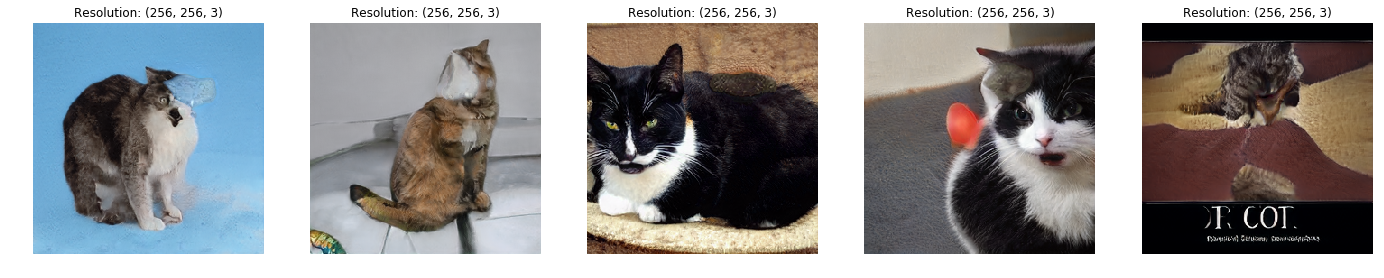

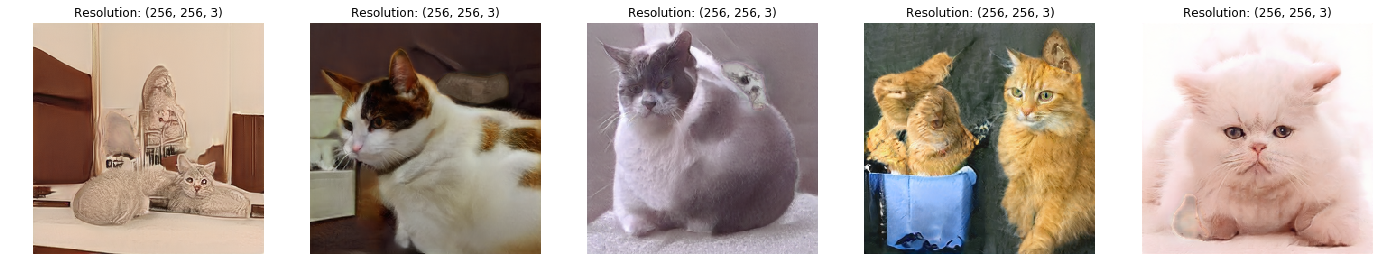

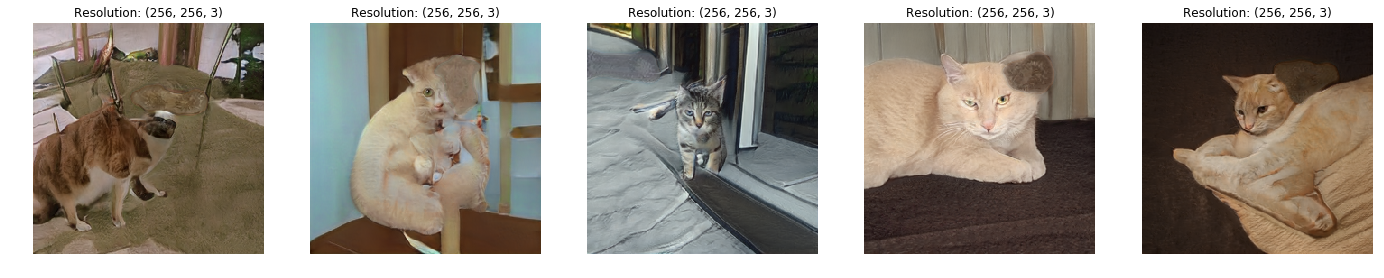

In [43]:
plot_imgs(input_gs, 3, 5)

## Samples from the converted input model at new resolution:

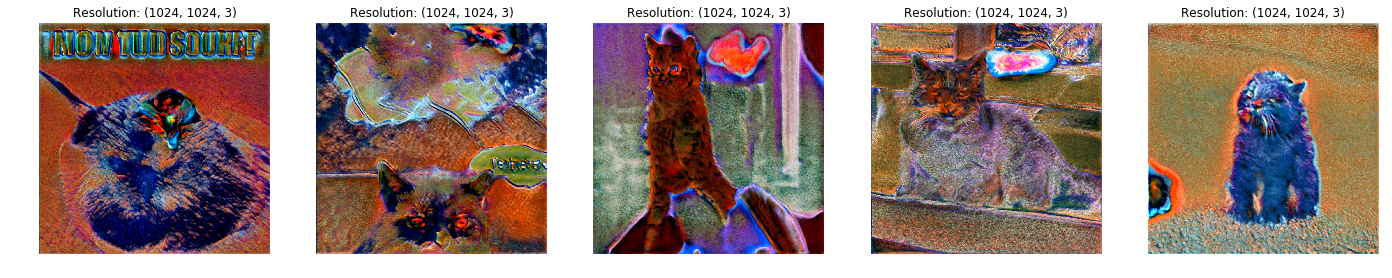

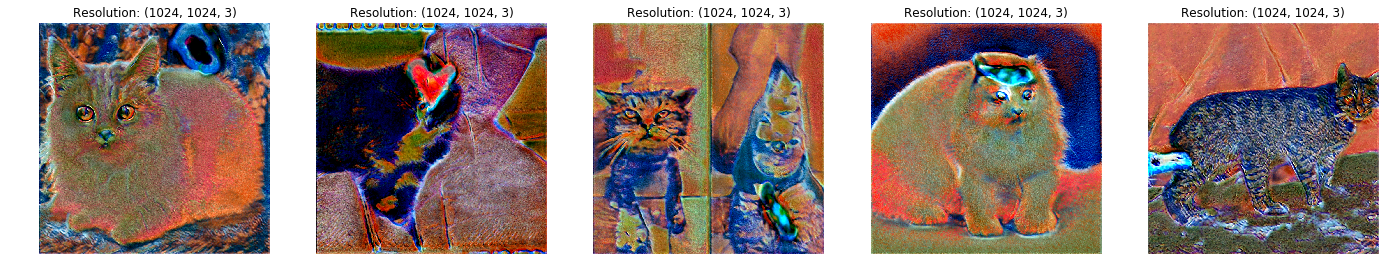

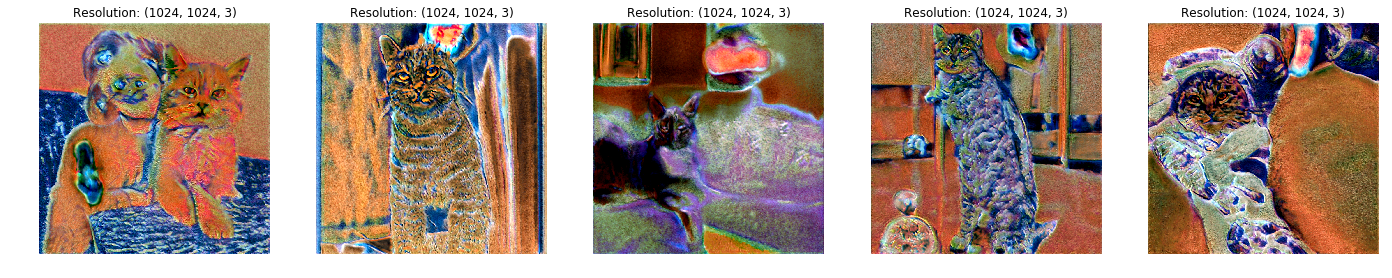

In [44]:
plot_imgs(target_gs, 3, 5)

## Save the new model to disk:

In [47]:
from training import misc

# Thousands of images per training_lod_phase (see stylegan/training/training_loop.py)
kimg_per_lod = 600 + 600
resume_kimg = int((np.log2(input_res)-1) * kimg_per_lod)

pkl = 'models/new_%04d_model_with_%04d_base.pkl' %(target_res, input_res)
misc.save_pkl((target_g, target_d, target_gs), pkl)

print("New %d model saved to %s" %(target_res, pkl))
print("\n *** When finetuning this model, you should set \"resume_kimg\" to %d  (I think :p)" %resume_kimg)

New 1024 model saved to models/new_1024_model_with_0256_base.pkl

 *** When finetuning this model, you should set "resume_kimg" to 8400  (I think :p)


## Good luck finetuning!
## Btw, I'm looking for as many public StyleGAN models as I can find, wanna share yours?
## ----> Tweet / PM me at @xsteenbrugge

![alt text](http://www.sherv.net/cm/emoticons/hand-gestures/dap-greeting-smiley-emoticon.gif)